In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from parse_tree import *
from genetic_programming import IrisGP
from visualizations import Visualizations

In [ ]:
iris = pd.read_csv("../data/Iris.csv")
train_df, test_df = train_test_split(iris, test_size=0.2, random_state=3)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [204]:
random.seed(2)

FUNCTION_SET = ["+", "-", "*", "/"]
# F = ["+", "-", "*", "/", "sin", "cos", "ln"]
TERMINAL_RULES = TerminalGenerationRules(
    ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"],
    (-10, 10),
    ints_only=False,
    no_random_constants=False,
)
MAX_DEPTH = 3
TERMINAL_PROBABILITY = 0.2
g = IrisGP(
    FUNCTION_SET,
    TERMINAL_RULES,
    MAX_DEPTH,
    TERMINAL_PROBABILITY,
)

POPULATION_SIZE = 50
GENERATIONS = 30
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.9
NUM_PARENTS_TO_SURVIVE = int(POPULATION_SIZE * 0.1)
best, fitness, history = g.solve(POPULATION_SIZE, GENERATIONS,CROSSOVER_RATE, MUTATION_RATE, NUM_PARENTS_TO_SURVIVE, train_df)

In [205]:
print(history)
print(fitness)

[47.92, 50.74, 56.1, 58.44, 65.6, 75.68, 67.62, 72.74, 79.48, 72.9, 72.18, 69.94, 87.58, 80.7, 80.4, 81.62, 75.94, 82.08, 79.42, 79.48, 73.22, 85.84, 92.98, 92.02, 88.46, 81.48, 82.76, 81.7, 86.8, 71.7]
113


In [206]:
IrisGP.evaluate_fitness(best, test_df)

28

In [200]:
best

(* (/ PetalWidthCm (+ PetalWidthCm SepalWidthCm)) (+ (/ (- PetalWidthCm SepalWidthCm) -8.3767) (- (/ PetalLengthCm PetalLengthCm) (/ -4.4704 6.6473))))

In [201]:
vis = Visualizations(best, test_df)

In [202]:
vis.test_results[vis.test_results["Correct"] == False]

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Correct,PredictedValue,PredictedSpecies
72,73,6.3,2.5,4.9,1.5,Iris-versicolor,False,0.67196,Iris-virginica
134,135,6.1,2.6,5.6,1.4,Iris-virginica,False,0.635519,Iris-versicolor


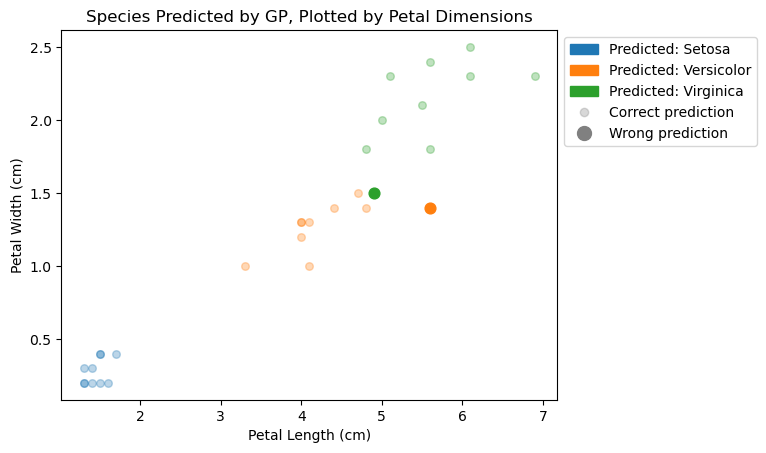

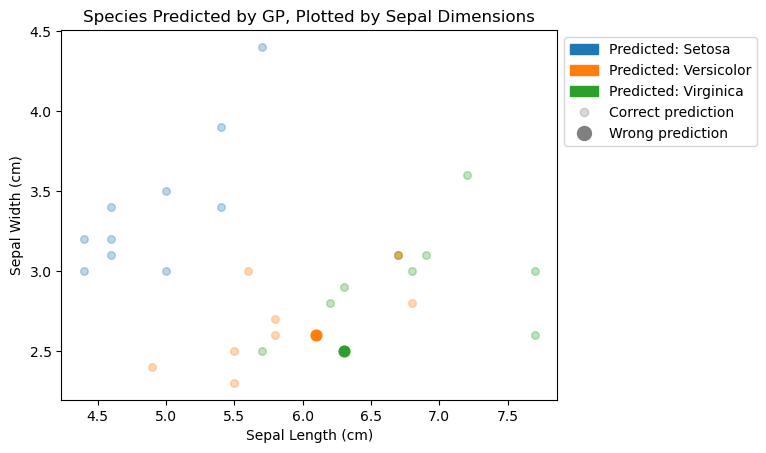

In [203]:
vis.plot_predictions_by_dimension("Petal")
vis.plot_predictions_by_dimension("Sepal")

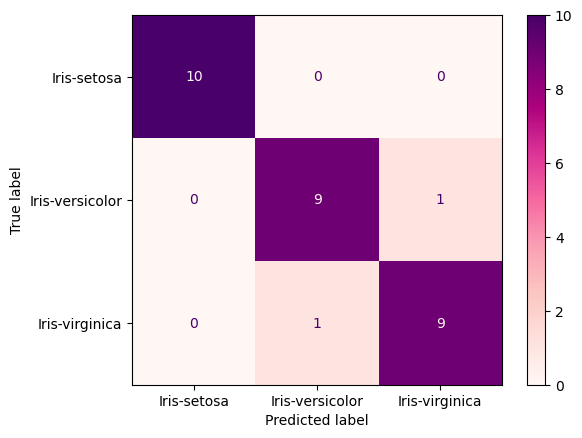

In [207]:
vis.plot_confusion_matrix()